In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

# Is that Pokemon a water type?

In this notebook we will examine whether we can predict a specific type of pokemon, namely water type. Our motivation for doing this is that there a total of 18 different types, and so developing a model that can predict any pokemon type may prove difficult. Therefore we will first develop a model that can predict the most common type, Water, and use the lesssons learned here to move on to more complicated models.

Let's start by cleaning up the data.

In [47]:
df_master = pd.read_csv('../data/pokemon_alopez247.csv')
df_master = df_master.set_index('Number')

print 'There are %s total features in the data set. \n' % len( list(df_master))
print list(df_master)
print ''
print 'Let''s get rid of a few features that we won''t need for this exercise.'
print 'We will also get rid of all Legendary pokemon from the data for simplicity. \n'
print 'This leaves us with the data set shown below.'

df_master = df_master[ df_master.isLegendary == False]
df_master = df_master.drop([ 'isLegendary', 'hasMegaEvolution', 'Generation', 'Pr_Male'], axis=1)
df_master.head()

There are 22 total features in the data set. 

['Name', 'Type_1', 'Type_2', 'Total', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Generation', 'isLegendary', 'Color', 'hasGender', 'Pr_Male', 'Egg_Group_1', 'Egg_Group_2', 'hasMegaEvolution', 'Height_m', 'Weight_kg', 'Catch_Rate', 'Body_Style']

Lets get rid of a few features that we wont need for this exercise.
We will also get rid of all Legendary pokemon from the data for simplicity. 

This leaves us with the data set shown below.


,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Color,hasGender,Egg_Group_1,Egg_Group_2,Height_m,Weight_kg,Catch_Rate,Body_Style
Number,,,,,,,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,Green,True,Monster,Grass,0.71,6.9,45,quadruped
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,Green,True,Monster,Grass,0.99,13.0,45,quadruped
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,Green,True,Monster,Grass,2.01,100.0,45,quadruped
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,Red,True,Monster,Dragon,0.61,8.5,45,bipedal_tailed
5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,Red,True,Monster,Dragon,1.09,19.0,45,bipedal_tailed


Pokemon can take on a variety of different types. Lets take a look at the frequency of different Pokemon types by combining the feature values of `Type_1` and `Type_2`.

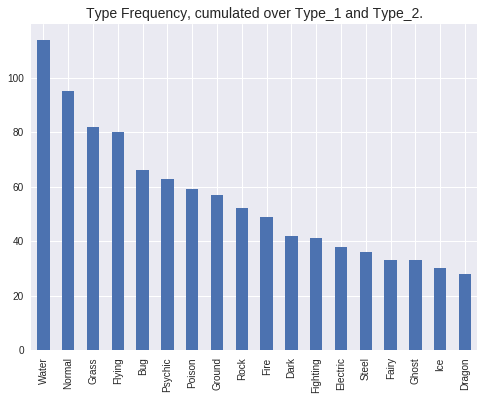

In [4]:
typeCombo = pd.Series( df_master['Type_1'].value_counts() + df_master['Type_2'].value_counts())
typeCombo = typeCombo.sort_values( ascending=False)

plt.figure( figsize=(8,6))
plt.title( 'Type Frequency, cumulated over Type_1 and Type_2.', fontsize=14)
typeCombo.plot( kind='bar')

As shown above, Water type is the most prevelant.

Now let's turn our attention to trying to predict whether a pokemon is water type or not.

## Data examination and preparation

In order to perform our analysis we first need to transform the `Type_1` and `Type_2` features into a feature that indicates whether the pokemon is or is not water type. We will name this binary categorical feature `Water`.

In [84]:
df_water = df_master
df_water.Type_2.loc[ df_master['Type_2'].isnull() == True] = ''
typeSeries = df_water['Type_1'] + '|' + df_water['Type_2']
typeMatrix = typeSeries.str.get_dummies('|')

df_water = pd.merge( typeMatrix, df_water.drop([ 'Type_1', 'Type_2'], axis=1), left_index=True, right_index=True)
df_water = df_water.drop(['Grass', 'Fire', 'Flying', 'Bug', 'Normal',
                          'Poison', 'Electric', 'Ground', 'Fairy',
                          'Fighting', 'Psychic', 'Rock', 'Ghost',
                          'Ice', 'Dragon', 'Dark', 'Steel'], axis=1)

df_water.head()

,Water,Name,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Color,hasGender,Egg_Group_1,Egg_Group_2,Height_m,Weight_kg,Catch_Rate,Body_Style
Number,,,,,,,,,,,,,,,,,
1,0,Bulbasaur,318,45,49,49,65,65,45,Green,True,Monster,Grass,0.71,6.9,45,quadruped
2,0,Ivysaur,405,60,62,63,80,80,60,Green,True,Monster,Grass,0.99,13.0,45,quadruped
3,0,Venusaur,525,80,82,83,100,100,80,Green,True,Monster,Grass,2.01,100.0,45,quadruped
4,0,Charmander,309,39,52,43,60,50,65,Red,True,Monster,Dragon,0.61,8.5,45,bipedal_tailed
5,0,Charmeleon,405,58,64,58,80,65,80,Red,True,Monster,Dragon,1.09,19.0,45,bipedal_tailed


Looking at the data, there a several features that are numerical data. I am curious as to see whether these numerical features are enough to predict whether a pokemon is a water type or not. Let's take a quick look at the numerical features to see if water types take on distribution of values distinct from non-water types.

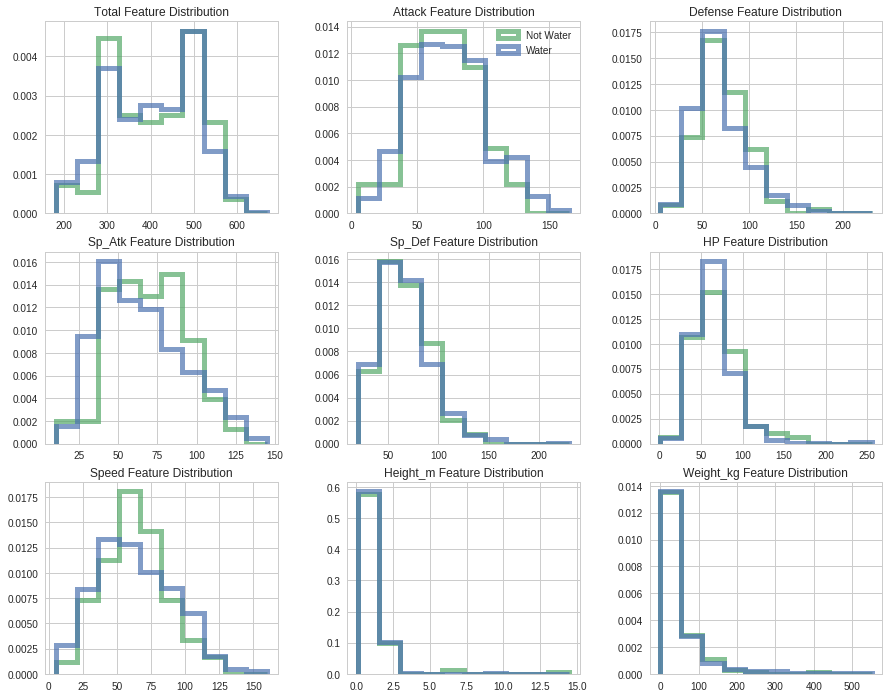

In [93]:
numFeatures = [ 'Total', 'Attack', 'Defense',
                'Sp_Atk', 'Sp_Def', 'HP', 'Speed',
                'Height_m', 'Weight_kg']

for feature in numFeatures:
    df_water[ feature] = df_water[ feature].astype('float64')

plt.figure( figsize=(15,12))
plt.subplots_adjust( hspace=0.2, wspace=0.3)     
plt.legend( ['Not Water', 'Water'])
for i, feat in enumerate( numFeatures):
    iSubFig = i + 1
    plt.subplot( 3, 3, iSubFig)
    plt.hist( [df_water[feat][ df_water.Water==0],
               df_water[feat][ df_water.Water==1]], normed=True, histtype='step', linewidth=5, alpha=0.7)
    plt.title(feat+' Feature Distribution')
    if i == 1:
        plt.legend( ['Not Water', 'Water'])

As shown above, there is very little distinction between water and non-water types in these categories.
Therefore using these features predict water type may not be effective. nonetheless, let's trying making a predictive model and see how well it performs.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model    import LogisticRegression
from sklearn.pipeline        import Pipeline
from sklearn import metrics
from sklearn import preprocessing

In [10]:
# gridsearch estimator
pipe = Pipeline( steps=[( 'clfLog', LogisticRegression())] )
estimator = GridSearchCV( pipe,
                         dict( clfLog__C=np.logspace(-4, 4, 5)) )

In [11]:
# split data into features and output
columnIdx = df_water.columns
features  = df_water[ columnIdx[1:]]
typeWater = df_water['Water']

In [12]:
estimator.fit( features, typeWater)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('clfLog', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clfLog__C': array([  1.00000e-04,   1.00000e-02,   1.00000e+00,   1.00000e+02,
         1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

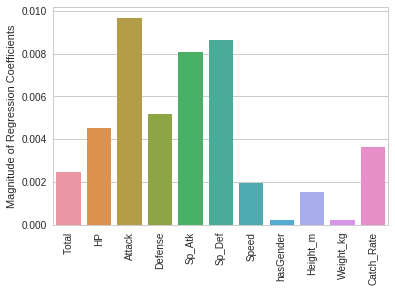

In [13]:
clfLog_coef = estimator.best_estimator_.named_steps['clfLog'].coef_[0]
features.columns
sns.set_style("whitegrid")
sns.barplot( x=features.columns, y=abs(clfLog_coef))
plt.xticks(rotation=90);
plt.ylabel('Magnitude of Regression Coefficients')

In [14]:
print 'Accuracy of model = %.3f'  % estimator.best_score_

Accuracy of model = 0.831


In [15]:
# get best performing model from estimator
clf_log = estimator.best_estimator_
# Make training and test data sets so that we can produce a classification report.
X_train, X_test, y_train, y_test = train_test_split( features, typeWater, test_size=0.50, random_state=11)
y_predict = clf_log.predict( X_test)
print 'Summary metrics for Logistic Regression: \n %s' \
        % metrics.classification_report( y_test, y_predict)

Summary metrics for Logistic Regression: 
              precision    recall  f1-score   support

          0       0.82      1.00      0.90       278
          1       0.00      0.00      0.00        60

avg / total       0.68      0.82      0.74       338



/home/julien/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As you can see, although the model has an accuracy of 83%, in fact it did not perform very well since none of the water types (class = 1) were correctly predicted.

### Battle Attribute Normalization

Let's try some feature normalization in order to improve our results. We will normalize the pokemon battle attributes `HP`, `Attack`, `Defense`, `Sp_Atk`, `Sp_Def` and `Speed`. The sume of all these features is the Pokemon's `Total`. Some pokemon are inherently stronger than others, so they will have all around higher battle attributes than weaker pokemon. In order to have all pokemon on an even footing, we will normalize the battle features by the `Total`.

In [16]:
battleFeatures = [ 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'HP', 'Speed']
for b in battleFeatures:
    df_water[b] = df_water[b] / df_water['Total']

In [17]:
# split data into features and output
columnIdx = df_water.columns
features  = df_water[ columnIdx[1:]]
typeWater = df_water['Water']

df_water.head()

,Water,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,hasGender,Height_m,Weight_kg,Catch_Rate
Number,,,,,,,,,,,,
1,0,318.0,0.141509,0.154088,0.154088,0.204403,0.204403,0.141509,1.0,0.71,6.9,45.0
2,0,405.0,0.148148,0.153086,0.155556,0.197531,0.197531,0.148148,1.0,0.99,13.0,45.0
3,0,525.0,0.152381,0.156190,0.158095,0.190476,0.190476,0.152381,1.0,2.01,100.0,45.0
4,0,309.0,0.126214,0.168285,0.139159,0.194175,0.161812,0.210356,1.0,0.61,8.5,45.0
5,0,405.0,0.143210,0.158025,0.143210,0.197531,0.160494,0.197531,1.0,1.09,19.0,45.0


Accuracy of model = 0.831


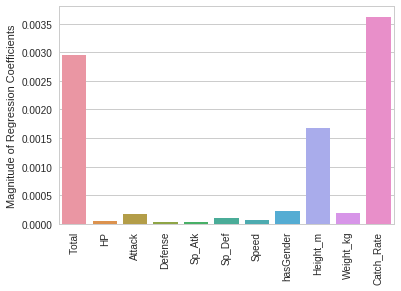

In [18]:
# gridsearch estimator
pipe = Pipeline( steps=[( 'clfLog', LogisticRegression())] )
estimator = GridSearchCV( pipe,
                         dict( clfLog__C=np.logspace(-4, 4, 5)) )

estimator.fit( features, typeWater)
print 'Accuracy of model = %.3f'  % estimator.best_score_

clfLog_coef = estimator.best_estimator_.named_steps['clfLog'].coef_[0]
features.columns
sns.set_style("whitegrid")
sns.barplot( x=features.columns, y=abs(clfLog_coef))
plt.xticks(rotation=90);
plt.ylabel('Magnitude of Regression Coefficients')

In [19]:
# get best performing model from estimator
clf_log = estimator.best_estimator_
# Make training and test data sets so that we can produce a classification report.
X_train, X_test, y_train, y_test = train_test_split( features, typeWater, test_size=0.50, random_state=11)
y_predict = clf_log.predict( X_test)
print 'Summary metrics for Logistic Regression: \n %s' \
        % metrics.classification_report( y_test, y_predict)

Summary metrics for Logistic Regression: 
              precision    recall  f1-score   support

          0       0.82      1.00      0.90       278
          1       0.00      0.00      0.00        60

avg / total       0.68      0.82      0.74       338



In the above model, we normalized the battle attributes by `Total` but kept the other features as they were. This caused the a drastic change in the distribution of the regression coefficients.

Let's standardize the `Total`, `Height_m`, `Weight_kg` and `Catch_Rate` features in order to avoid this.

In [20]:
scaler = preprocessing.StandardScaler()
scaler.fit( df_water[ [ 'Total', 'Height_m', 'Weight_kg', 'Catch_Rate']] )
#print scaler.mean_
#print scaler.transform( df_water[ [ 'Total', 'Height_m', 'Weight_kg', 'Catch_Rate']])
df_water[ [ 'Total', 'Height_m', 'Weight_kg', 'Catch_Rate']] = scaler.transform( df_water[ [ 'Total', 'Height_m', 'Weight_kg', 'Catch_Rate']])

features  = df_water[ columnIdx[1:]]
typeWater = df_water['Water']

df_water.head()

,Water,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,hasGender,Height_m,Weight_kg,Catch_Rate
Number,,,,,,,,,,,,
1,0,-0.874175,0.141509,0.154088,0.154088,0.204403,0.204403,0.141509,1.0,-0.377269,-0.606716,-0.822972
2,0,0.008507,0.148148,0.153086,0.155556,0.197531,0.197531,0.148148,1.0,-0.072030,-0.514169,-0.822972
3,0,1.226001,0.152381,0.156190,0.158095,0.190476,0.190476,0.152381,1.0,1.039913,0.805761,-0.822972
4,0,-0.965487,0.126214,0.168285,0.139159,0.194175,0.161812,0.210356,1.0,-0.486283,-0.582441,-0.822972
5,0,0.008507,0.143210,0.158025,0.143210,0.197531,0.160494,0.197531,1.0,0.036984,-0.423139,-0.822972


Accuracy of model = 0.831


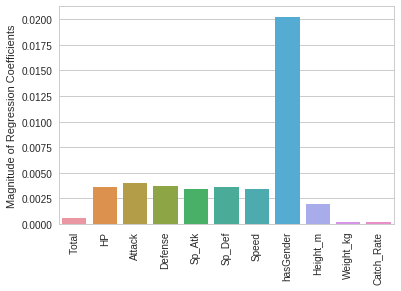

In [21]:
# gridsearch estimator
pipe = Pipeline( steps=[( 'clfLog', LogisticRegression())] )
estimator = GridSearchCV( pipe,
                         dict( clfLog__C=np.logspace(-4, 4, 5)) )

estimator.fit( features, typeWater)
print 'Accuracy of model = %.3f'  % estimator.best_score_

clfLog_coef = estimator.best_estimator_.named_steps['clfLog'].coef_[0]
features.columns
sns.set_style("whitegrid")
sns.barplot( x=features.columns, y=abs(clfLog_coef))
plt.xticks(rotation=90);
plt.ylabel('Magnitude of Regression Coefficients')

In [22]:
# get best performing model from estimator
clf_log = estimator.best_estimator_
# Make training and test data sets so that we can produce a classification report.
X_train, X_test, y_train, y_test = train_test_split( features, typeWater, test_size=0.50, random_state=11)
y_predict = clf_log.predict( X_test)
print 'Summary metrics for Logistic Regression: \n %s' \
        % metrics.classification_report( y_test, y_predict)

Summary metrics for Logistic Regression: 
              precision    recall  f1-score   support

          0       0.82      1.00      0.90       278
          1       0.00      0.00      0.00        60

avg / total       0.68      0.82      0.74       338



Normalizing the other features did not change the results. Let's try normalizing all features.

Accuracy of model = 0.830


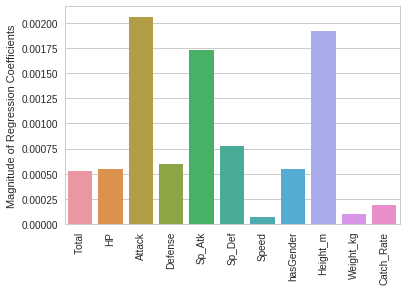

Summary metrics for Logistic Regression: 
              precision    recall  f1-score   support

          0       0.82      1.00      0.90       278
          1       1.00      0.02      0.03        60

avg / total       0.86      0.83      0.75       338



In [23]:
featureList = ['HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'hasGender']

scaler = preprocessing.StandardScaler()
scaler.fit( df_water[ featureList] )
df_water[ featureList] = scaler.transform( df_water[ featureList])

features  = df_water[ columnIdx[1:]]
typeWater = df_water['Water']

df_water.head()

# gridsearch estimator
pipe = Pipeline( steps=[( 'clfLog', LogisticRegression())] )
estimator = GridSearchCV( pipe,
                         dict( clfLog__C=np.logspace(-4, 4, 5)) )

estimator.fit( features, typeWater)
print 'Accuracy of model = %.3f'  % estimator.best_score_

clfLog_coef = estimator.best_estimator_.named_steps['clfLog'].coef_[0]
features.columns
sns.set_style("whitegrid")
sns.barplot( x=features.columns, y=abs(clfLog_coef))
plt.xticks(rotation=90);
plt.ylabel('Magnitude of Regression Coefficients')
plt.show()

# get best performing model from estimator
clf_log = estimator.best_estimator_
# Make training and test data sets so that we can produce a classification report.
X_train, X_test, y_train, y_test = train_test_split( features, typeWater, test_size=0.50, random_state=11)
y_predict = clf_log.predict( X_test)
print 'Summary metrics for Logistic Regression: \n %s' \
        % metrics.classification_report( y_test, y_predict)

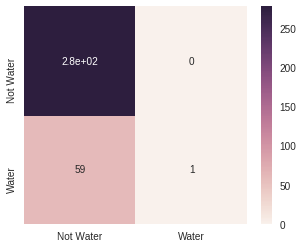

In [24]:
df_cm = pd.DataFrame( metrics.confusion_matrix( y_test,  y_predict),
                     index=[ 'Not Water', 'Water'], columns=[ 'Not Water', 'Water'])
plt.figure(figsize = (5,4))
sns.heatmap(df_cm, annot=True)

Above is a matrix of the true values of the data (vertical axis) and the predicted values (horizontal axis). All non-water types were correctly predicted as such, but only one water type was correctly classified.

We are starting to get some water type predictions out of the model, but only one pokemon was correctly predicted as a water type.

## Adding additional features to the model

Let's see if other features of the pokemon can improve our model's accuracy.

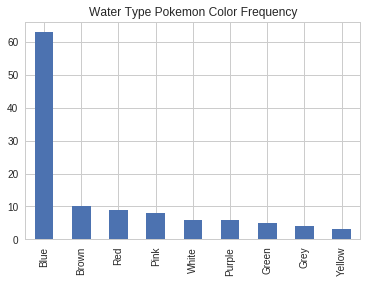

In [25]:
df_master[ df_water.Water==1].Color.value_counts().plot( kind='bar')
plt.title('Water Type Pokemon Color Frequency')

Unsurprisingly, the vast majority of water type pokemon are blue in color.

As shown below, water type pokemon also come predominantly from a few different types of egg groups and body styles.

Therefore, let's use this information to predict water type.

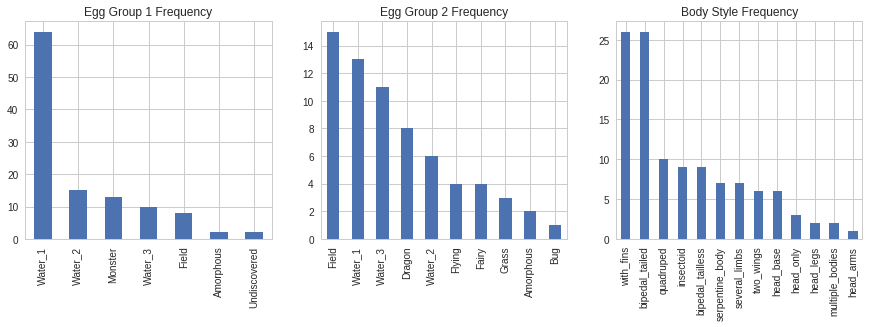

In [26]:
plt.figure( figsize=(15,4))
plt.subplots_adjust( hspace=0.4, wspace=0.2)

plt.subplot(1,3,1)
plt.title('Egg Group 1 Frequency')
df_master[ df_water.Water==1].Egg_Group_1.value_counts().plot( kind='bar')

plt.subplot(1,3,2)
plt.title('Egg Group 2 Frequency')
df_master[ df_water.Water==1].Egg_Group_2.value_counts().plot( kind='bar')

plt.subplot(1,3,3)
plt.title('Body Style Frequency')
df_master[ df_water.Water==1].Body_Style.value_counts().plot( kind='bar')

In [27]:
dfList = [ df_water['Water'], df_master[ ['Color', 'Egg_Group_1', 'Egg_Group_2', 'Body_Style']] ]
df_w2  = pd.concat( dfList, axis=1)
df_w2.head()

,Water,Color,Egg_Group_1,Egg_Group_2,Body_Style
Number,,,,,
1,0,Green,Monster,Grass,quadruped
2,0,Green,Monster,Grass,quadruped
3,0,Green,Monster,Grass,quadruped
4,0,Red,Monster,Dragon,bipedal_tailed
5,0,Red,Monster,Dragon,bipedal_tailed


In [28]:
colorMatrix     = df_w2.Color.str.get_dummies()
bodyStyleMatrix = df_w2.Body_Style.str.get_dummies()

eggG1Matrix = df_w2.Egg_Group_1.str.get_dummies()
eggG2Matrix = df_w2.Egg_Group_2.str.get_dummies()

eggMatrix = eggG1Matrix + eggG2Matrix
eggMatrix = eggMatrix.drop( ['Ditto', 'Undiscovered'], axis=1)
eggMatrix.tail(10)

,Amorphous,Bug,Dragon,Fairy,Field,Flying,Grass,Human-Like,Mineral,Monster,Water_1,Water_2,Water_3
Number,,,,,,,,,,,,,
706,0,0,1,0,0,0,0,0,0,0,0,0,0
707,0,0,0,0,0,0,0,0,1,0,0,0,0
708,1,0,0,0,0,0,1,0,0,0,0,0,0
709,1,0,0,0,0,0,1,0,0,0,0,0,0
710,1,0,0,0,0,0,0,0,0,0,0,0,0
711,1,0,0,0,0,0,0,0,0,0,0,0,0
712,0,0,0,0,0,0,0,0,0,1,0,0,0
713,0,0,0,0,0,0,0,0,0,1,0,0,0
714,0,0,0,0,0,1,0,0,0,0,0,0,0


In [29]:
dfList = [ df_water['Water'], colorMatrix, eggMatrix, bodyStyleMatrix]
df_w2  = pd.concat( dfList, axis=1)
df_w2.head()

,Water,Black,Blue,Brown,Green,Grey,Pink,Purple,Red,White,...,head_base,head_legs,head_only,insectoid,multiple_bodies,quadruped,serpentine_body,several_limbs,two_wings,with_fins
Number,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Accuracy of model = 0.938


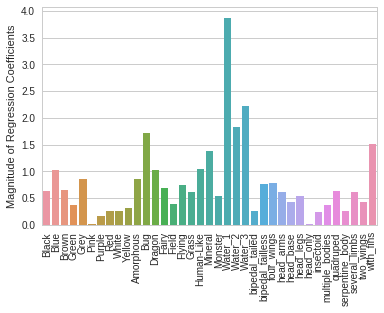

Summary metrics for Logistic Regression: 
              precision    recall  f1-score   support

          0       0.99      0.98      0.98       278
          1       0.90      0.93      0.92        60

avg / total       0.97      0.97      0.97       338



In [30]:
columnIdx = df_w2.columns
features  = df_w2[ columnIdx[1:]]
typeWater = df_w2['Water']

# gridsearch estimator
pipe = Pipeline( steps=[( 'clfLog', LogisticRegression())] )
estimator = GridSearchCV( pipe,
                         dict( clfLog__C=np.logspace(-4, 4, 5)) )

estimator.fit( features, typeWater)
print 'Accuracy of model = %.3f'  % estimator.best_score_

clfLog_coef = estimator.best_estimator_.named_steps['clfLog'].coef_[0]
features.columns
sns.set_style("whitegrid")
sns.barplot( x=features.columns, y=abs(clfLog_coef))
plt.xticks(rotation=90);
plt.ylabel('Magnitude of Regression Coefficients')
plt.show()

# get best performing model from estimator
clf_log = estimator.best_estimator_
# Make training and test data sets so that we can produce a classification report.
X_train, X_test, y_train, y_test = train_test_split( features, typeWater, test_size=0.50, random_state=11)
y_predict = clf_log.predict( X_test)
print 'Summary metrics for Logistic Regression: \n %s' \
        % metrics.classification_report( y_test, y_predict)

We see that using the phyiscal characteristics of `Color`, `Egg_Group1`, `Egg_Group2` and `Body_Style` is much more effective at predicting type than using the battle attributes.

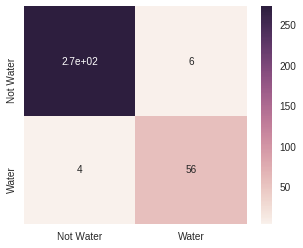

In [31]:
df_cm = pd.DataFrame( metrics.confusion_matrix( y_test,  y_predict),
                     index=[ 'Not Water', 'Water'], columns=[ 'Not Water', 'Water'])
plt.figure(figsize = (5,4))
sns.heatmap(df_cm, annot=True)